In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, learning_curve, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.decomposition import PCA

## Datenimport
Quelle der Daten: https://data.milwaukee.gov/dataset/property-sales-data

In [2]:
FILEPATH = os.path.join('..', 'input', 'armslengthsales_2022_valid.csv')

In [3]:
df = pd.read_csv(FILEPATH)

# Hilfsfunktionen

In [4]:
def evaluate_model(model_name, ct, pipe, train_data, test_data, X, y):
    cv = cross_val_score(estimator=pipe[-1], X=ct.fit_transform(train_data[X]), y=train_data[y], cv=10, n_jobs=4)
    in_sample_mae = mean_absolute_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X]))
    in_sample_mape = mean_absolute_percentage_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X]))*100
    out_of_sample_mae = mean_absolute_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X]))
    out_of_sample_mape = mean_absolute_percentage_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X]))*100
    out_of_sample_rsme = np.sqrt(mean_squared_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X])))
    out_of_sample_r2 = pipe.score(X=test_data[X], y=test_data[y])
    
    data = pd.DataFrame({
        'model': [model_name],
        'cv_mean': [cv.mean()],
        'in_sample_mae': [in_sample_mae],
        'in_sample_mape': [in_sample_mape],
        'out_of_sample_mae': [out_of_sample_mae],
        'out_of_sample_mape': [out_of_sample_mape],
        'out_of_sample_rsme': [out_of_sample_rsme],
        'out_of_sample_r2': [out_of_sample_r2],
        'cv': [cv]
    })
    data = data.set_index('model')
    return data

def print_evaluation(metrics):
    print(f'{metrics.index[0]} - Cross validation {metrics["cv"].iloc[0]}')
    print(f'{metrics.index[0]} - Cross validation mean: {metrics["cv_mean"].iloc[0]:.2f}')
    print(f'{metrics.index[0]} -      In-sample -  mae: {metrics["in_sample_mae"].iloc[0]:.2f}')
    print(f'{metrics.index[0]} -      In-sample - mape: {metrics["in_sample_mape"].iloc[0]:.2f}%')
    print(f'{metrics.index[0]} -  Out-of-sample -  mae: {metrics["out_of_sample_mae"].iloc[0]:.2f}')
    print(f'{metrics.index[0]} -  Out-of-sample - mape: {metrics["out_of_sample_mape"].iloc[0]:.2f}%')
    print(f'{metrics.index[0]} -  Out-of-sample - rsme: {metrics["out_of_sample_rsme"].iloc[0]:.2f}')
    print(f'{metrics.index[0]} -  Out-of-sample -   r2: {metrics["out_of_sample_r2"].iloc[0]:.2f}')

def plot_evaluation(name, ct, pipe, train_data, test_data, X, y):
    train_predictions = pipe.predict(train_data[X])
    test_predictions = pipe.predict(test_data[X])

    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.scatter(train_predictions, train_data[y], color='blue', label='Trainingsdaten')
    plt.scatter(test_predictions, test_data[y], color='red', label='Testdaten')
    plt.xlabel('Vorhergesagter Verkaufspreis')
    plt.ylabel('Tatsächlicher Verkaufspreis')
    plt.title(f'{name} - Vorhersagen vs. Tatsächliche Werte')
    plt.ticklabel_format(style='plain', axis='x') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.ticklabel_format(style='plain', axis='y') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.legend()

    cv_results = cross_validate(estimator=pipe[-1], X=ct.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    plt.subplot(3, 1, 2)
    plt.plot(range(len(train_scores)), train_scores, label='In-sample Score', marker='o')
    plt.plot(range(len(test_scores)), test_scores, label='Out-of-sample Score', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'{name} - Cross Validation - In-sample vs Out-of-sample Scores')
    plt.legend()

    train_sizes, train_scores, test_scores = learning_curve(pipe, train_data[X], train_data[y].values.ravel(), cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.subplot(3, 1, 3)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='In-sample score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Out-of-sample score')
    plt.xlabel('Steps')
    plt.ylabel('R2-Score')
    plt.legend(loc='best')
    plt.title(f'{name} - Learning Curve R2')

    plt.tight_layout()
    plt.show()

# Preprocessing

In [5]:
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Built']
df['Bath'] = df['Fbath']+(df['Hbath']/2)
df['Total_Rooms'] = df['Bdrms'] + df['Rooms']

df['District'] = df['District'].astype(object)
df['nbhd'] = df['nbhd'].astype(object)

num_features = ['Stories', 'Age', 'Total_Rooms', 'FinishedSqft', 'Units', 'Bath', 'Lotsize']
cat_features = ['District', 'nbhd', 'Extwall']

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

y = ['Sale_price']
X = [*num_features, *cat_features]

In [6]:
set_config(transform_output='pandas')

# Auffüllen der fehlenden Numerischen Werte mit dem Durchschnitt + Anwendung StandardScaler
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Auffüllen der fehlenden Kategorischen Werte mit den häufigsten Werten + Anwendung OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

prep = ColumnTransformer(
    remainder='drop',
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ],
)

prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Stories', 'Age', 'Total_Rooms',
                                  'FinishedSqft', 'Units', 'Bath', 'Lotsize']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['District', 'nbhd', 'Extwall'])])

In [7]:
prep_transformed = prep.fit_transform(X=train_data[X])
prep_transformed

,num__Stories,num__Age,num__Total_Rooms,num__FinishedSqft,num__Units,num__Bath,num__Lotsize,cat__District_1,cat__District_2,cat__District_3,...,cat__Extwall_Fiber Cement/Hardiplank,cat__Extwall_Masonary Frame,cat__Extwall_Masonry/Frame,cat__Extwall_Metal Siding,cat__Extwall_Other,cat__Extwall_Precast Masonary,cat__Extwall_Prem Wood,cat__Extwall_Stone,cat__Extwall_Stucco,cat__Extwall_Wood
59,2.040804,-0.309840,-0.624829,-0.148994,-0.069573,-0.115614,-0.250146,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3717,1.123395,0.107680,-1.643368,0.151981,0.333957,-2.092238,-0.104320,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,-0.711424,-0.265423,-0.624829,-0.138065,-0.069573,-0.115614,-0.054248,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2540,0.205985,0.311998,-0.115560,-0.121344,-0.069573,0.543260,-0.117382,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6225,0.205985,0.089913,0.054196,-0.048013,-0.002318,0.543260,-0.112956,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.711424,0.143213,-0.455073,-0.136535,-0.069573,-0.774489,-0.077469,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,-0.711424,0.463015,-0.794586,-0.168009,-0.069573,-0.774489,-0.141330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226,-0.711424,0.320881,0.223953,-0.095006,-0.002318,0.543260,-0.123188,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,-0.711424,0.063263,-0.455073,-0.161452,-0.069573,-0.774489,-0.047499,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelltraining und Evaluation

## Default Parameter

In [8]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42))
]

df_metrics_default_parameter = pd.DataFrame()

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())

    metrics = evaluate_model(name, prep, pipe, train_data, test_data, X, y)
    print_evaluation(metrics)
    df_metrics_default_parameter = pd.concat([df_metrics_default_parameter, metrics])

Decision Tree - Cross validation [ 0.69985828  0.45666806  0.40718871  0.76013852  0.33324967 -0.06887666
  0.90333651 -1.73091488  0.83903829 -0.02486825]
Decision Tree - Cross validation mean: 0.26
Decision Tree -      In-sample -  mae: 1183.42
Decision Tree -      In-sample - mape: 0.89%
Decision Tree -  Out-of-sample -  mae: 62751.34
Decision Tree -  Out-of-sample - mape: 29.14%
Decision Tree -  Out-of-sample - rsme: 141978.30
Decision Tree -  Out-of-sample -   r2: 0.90
Random Forest - Cross validation [0.39598519 0.76331115 0.72018395 0.77107987 0.7892326  0.47355848
 0.9708083  0.35247096 0.75443208 0.75207868]
Random Forest - Cross validation mean: 0.67
Random Forest -      In-sample -  mae: 27944.53
Random Forest -      In-sample - mape: 10.14%
Random Forest -  Out-of-sample -  mae: 52074.52
Random Forest -  Out-of-sample - mape: 22.37%
Random Forest -  Out-of-sample - rsme: 168480.15
Random Forest -  Out-of-sample -   r2: 0.86
Gradient Boosting - Cross validation [ 0.3280186  

In [9]:
df_metrics_default_parameter.round(2)

,cv_mean,in_sample_mae,in_sample_mape,out_of_sample_mae,out_of_sample_mape,out_of_sample_rsme,out_of_sample_r2,cv
model,,,,,,,,
Decision Tree,0.26,1183.42,0.89,62751.34,29.14,141978.30,0.90,"[0.6998582824381334, 0.45666805613000216, 0.40..."
Random Forest,0.67,27944.53,10.14,52074.52,22.37,168480.15,0.86,"[0.39598518834495466, 0.7633111504556389, 0.72..."
Gradient Boosting,0.58,65032.58,42.79,69481.11,37.85,160870.86,0.88,"[0.3280185963918443, 0.7872938995456898, 0.670..."


## Hyperparameter-Optimierung
Die verwendeteten Parameter orientieren sich an den Default Parametern der Modelle.

In [10]:
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'model__random_state': [42],
            'model__max_depth': [None, 5, 10, 20], #default=None
            'model__min_samples_split': [2, 5, 10], #default=2; values must be in range (2, inf) 
            'model__min_samples_leaf': [1, 2, 4] #default=1; values must be in range (1, inf)
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__random_state': [42],
            'model__n_estimators': [50, 100, 200], #default=100
            'model__max_depth': [None, 5, 10, 20], #default=None
            'model__min_samples_split': [2, 5, 10], #default=2; values must be in range (2, inf) 
            'model__min_samples_leaf': [1, 2, 4] #default=1; values must be in range (1, inf)
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__random_state': [42],
            'model__n_estimators': [50, 100, 200], #default=100
            'model__learning_rate': [0.05, 0.1, 0.2], #default=0.1
            'model__subsample': [0.5, 0.75, 1.0], #default=1.0; values must be in range (0.0, 1.0)
            'model__max_depth': [3, 5, 7], #default=3
            'model__min_samples_split': [2, 5, 10], #default=2; values must be in range (2, inf)
            'model__min_samples_leaf': [1, 2, 4] #default=1; values must be in range (1, inf)
        }
    }
}

best_params = {}

for name, model_info in param_grids.items():
    model = model_info['model']
    param_grid = model_info['params']

    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
    grid_search.fit(X=train_data[X], y=train_data[y].values.ravel())

    metrics = evaluate_model(name, prep, grid_search.best_estimator_, train_data, test_data, X, y)
    print(f'{metrics.index[0]} - Best parameter: {grid_search.best_params_}')
    print_evaluation(metrics)

    best_params[name] = {param.split('__', 1)[1]: value for param, value in grid_search.best_params_.items()}

Decision Tree - Best parameter: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 42}
Decision Tree - Cross validation [ 0.02919663  0.65822845  0.53557803  0.71785689  0.78531983  0.0477101
  0.53429034 -0.85358567  0.42055794  0.59775891]
Decision Tree - Cross validation mean: 0.35
Decision Tree -      In-sample -  mae: 57226.61
Decision Tree -      In-sample - mape: 23.70%
Decision Tree -  Out-of-sample -  mae: 63003.08
Decision Tree -  Out-of-sample - mape: 27.69%
Decision Tree -  Out-of-sample - rsme: 184273.51
Decision Tree -  Out-of-sample -   r2: 0.84
Random Forest - Best parameter: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'model__random_state': 42}
Random Forest - Cross validation [0.39598519 0.76331115 0.72018395 0.77107987 0.7892326  0.47355848
 0.9708083  0.35247096 0.75443208 0.75207868]
Random Forest - Cross validation mean: 0.67
Random For

In [11]:
best_params

{'Decision Tree': {'max_depth': 20,
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'random_state': 42},
 'Random Forest': {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100,
  'random_state': 42},
 'Gradient Boosting': {'learning_rate': 0.2,
  'max_depth': 7,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 200,
  'random_state': 42,
  'subsample': 1.0}}

## Evaluation - Decision Tree

Decision Tree - Cross validation [ 0.02919663  0.65822845  0.53557803  0.71785689  0.78531983  0.0477101
  0.53429034 -0.85358567  0.42055794  0.59775891]
Decision Tree - Cross validation mean: 0.35
Decision Tree -      In-sample -  mae: 57226.61
Decision Tree -      In-sample - mape: 23.70%
Decision Tree -  Out-of-sample -  mae: 63003.08
Decision Tree -  Out-of-sample - mape: 27.69%
Decision Tree -  Out-of-sample - rsme: 184273.51
Decision Tree -  Out-of-sample -   r2: 0.84


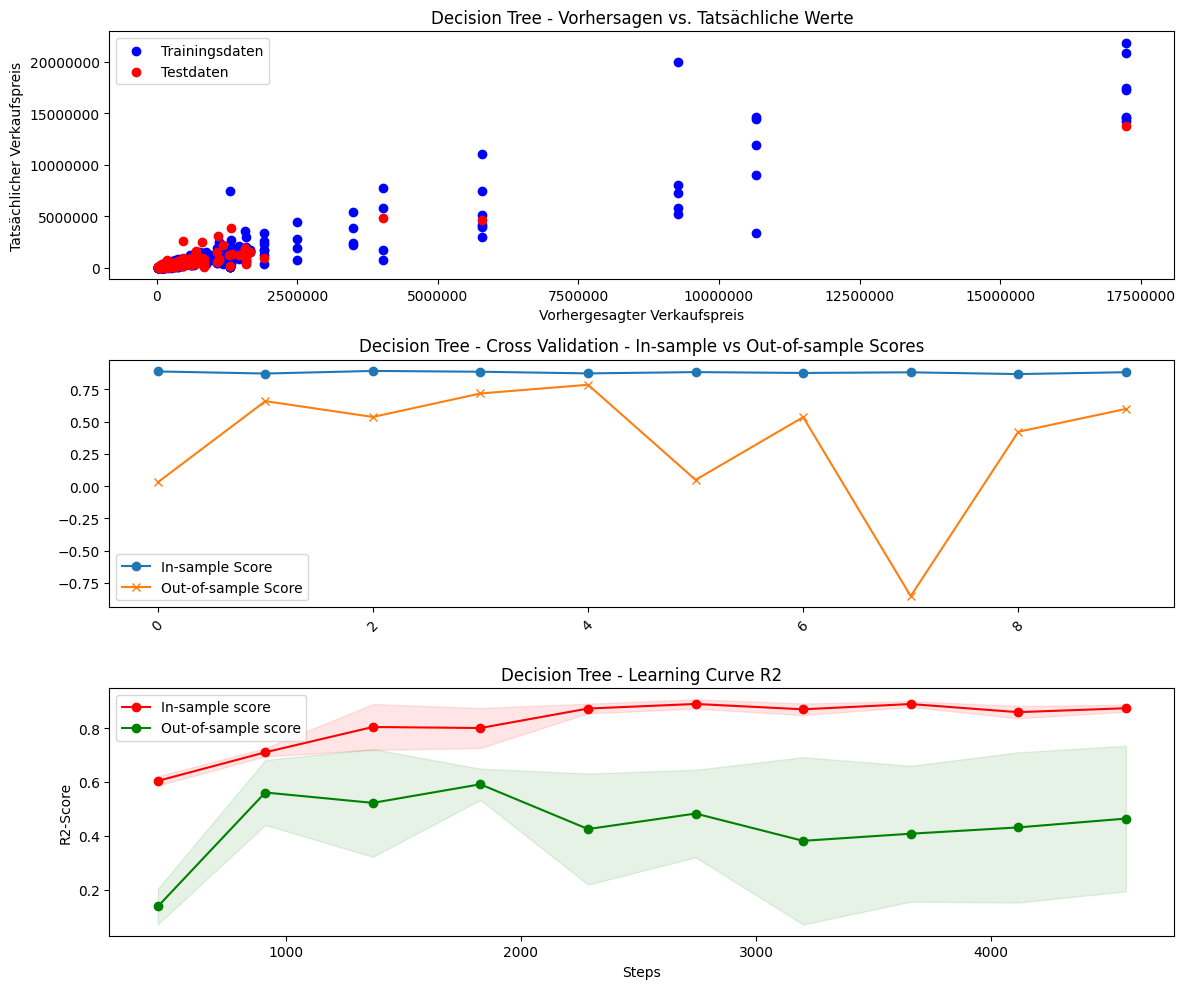

In [12]:
model_name = 'Decision Tree'

pipe_dt = Pipeline(steps=[
        ('preprocessor', prep),
        (model_name, DecisionTreeRegressor(**best_params[model_name]))
    ])

pipe_dt.fit(train_data[X], train_data[y].values.ravel())

metrics_dt = evaluate_model(model_name, prep, pipe_dt, train_data, test_data, X, y)
print_evaluation( metrics_dt)
plot_evaluation(model_name, prep, pipe_dt, train_data, test_data, X, y)

## Evaluation - Random Forest

Random Forest - Cross validation [0.39598519 0.76331115 0.72018395 0.77107987 0.7892326  0.47355848
 0.9708083  0.35247096 0.75443208 0.75207868]
Random Forest - Cross validation mean: 0.67
Random Forest -      In-sample -  mae: 27944.53
Random Forest -      In-sample - mape: 10.14%
Random Forest -  Out-of-sample -  mae: 52074.52
Random Forest -  Out-of-sample - mape: 22.37%
Random Forest -  Out-of-sample - rsme: 168480.15
Random Forest -  Out-of-sample -   r2: 0.86


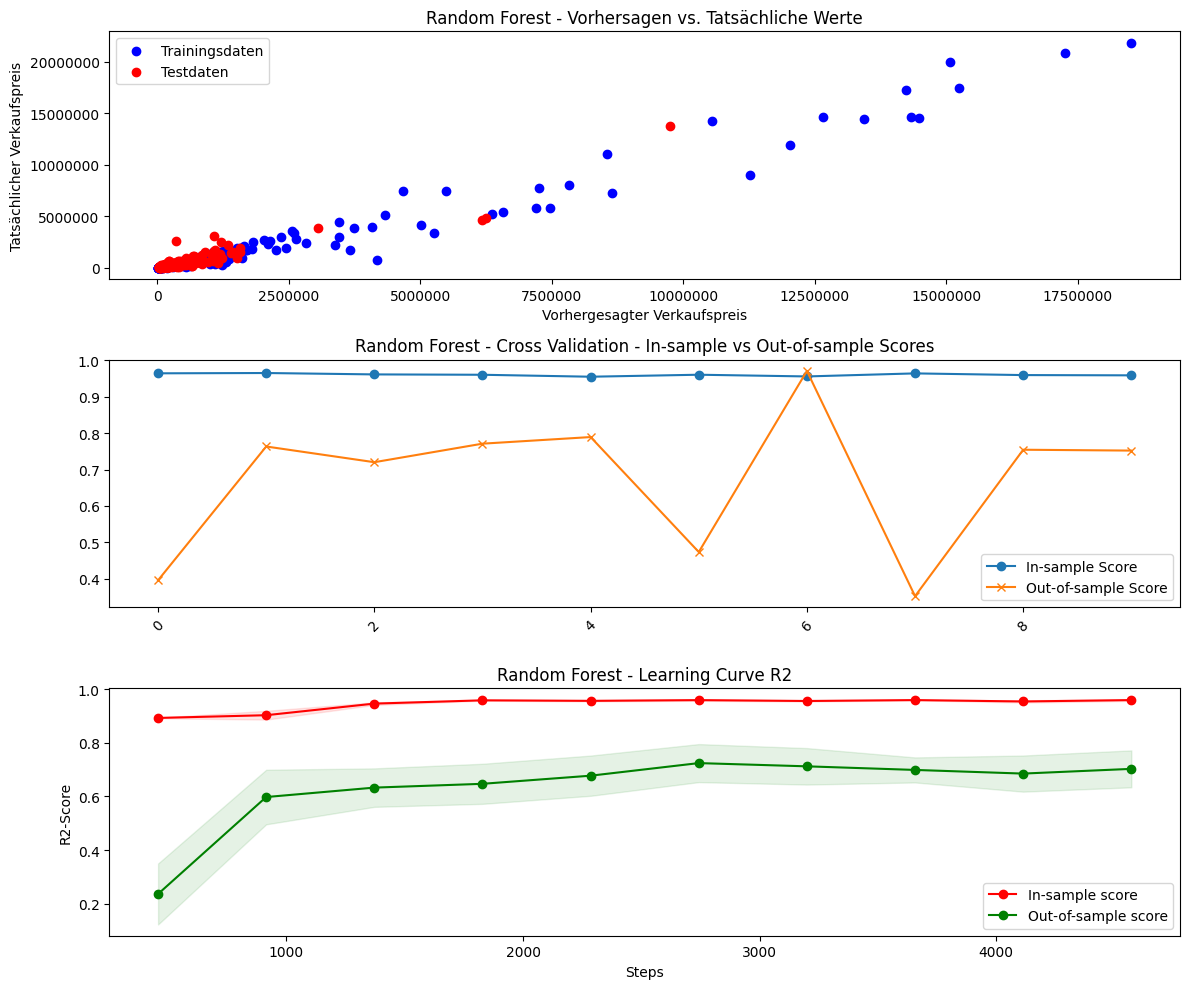

In [13]:
model_name = 'Random Forest'

pipe_rf = Pipeline(steps=[
        ('preprocessor', prep),
        (model_name, RandomForestRegressor(**best_params[model_name]))
    ])

pipe_rf.fit(train_data[X], train_data[y].values.ravel())

metrics_rf = evaluate_model(model_name, prep, pipe_rf, train_data, test_data, X, y)
print_evaluation(metrics_rf)
plot_evaluation(model_name, prep, pipe_rf, train_data, test_data, X, y)

## Evaluation - Gradient Boosting

Gradient Boosting - Cross validation [ 0.67819495  0.77212874  0.76491716  0.75943378  0.81810642  0.64074418
  0.94420904 -0.17222677  0.59348966  0.83067339]
Gradient Boosting - Cross validation mean: 0.66
Gradient Boosting -      In-sample -  mae: 27734.86
Gradient Boosting -      In-sample - mape: 16.77%
Gradient Boosting -  Out-of-sample -  mae: 50135.63
Gradient Boosting -  Out-of-sample - mape: 21.49%
Gradient Boosting -  Out-of-sample - rsme: 155735.12
Gradient Boosting -  Out-of-sample -   r2: 0.88


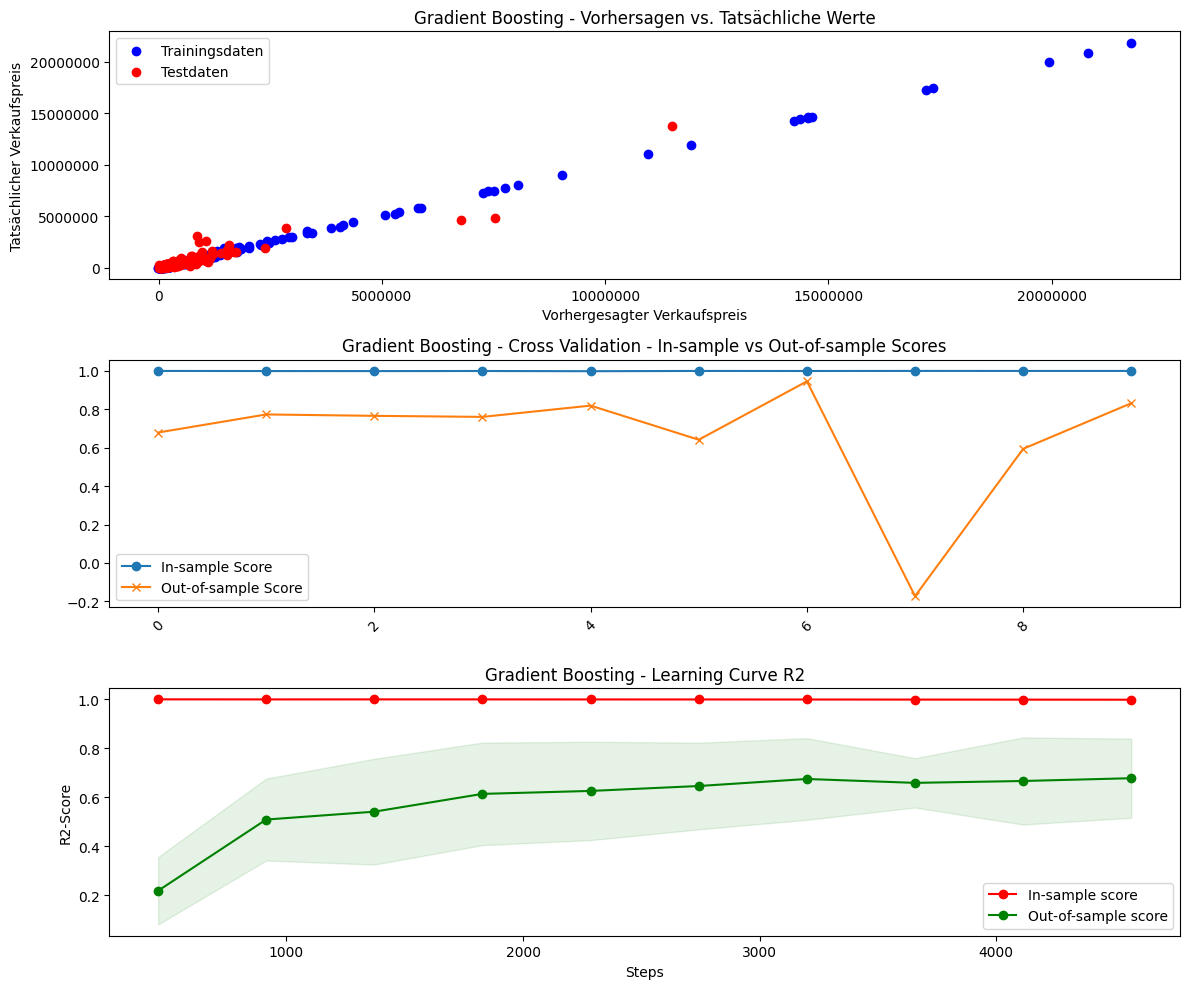

In [14]:
model_name = 'Gradient Boosting'

pipe_gb = Pipeline(steps=[
        ('preprocessor', prep),
        (model_name, GradientBoostingRegressor(**best_params[model_name]))
    ])

pipe_gb.fit(train_data[X], train_data[y].values.ravel())

metrics_gb = evaluate_model(model_name, prep, pipe_gb, train_data, test_data, X, y)
print_evaluation(metrics_gb)
plot_evaluation(model_name, prep, pipe_gb, train_data, test_data, X, y)

## Evaluation - Modellvergleich

In [15]:
df_metrics_optimized_parameter = pd.concat([metrics_dt, metrics_rf, metrics_gb])
df_metrics_optimized_parameter.round(2)

,cv_mean,in_sample_mae,in_sample_mape,out_of_sample_mae,out_of_sample_mape,out_of_sample_rsme,out_of_sample_r2,cv
model,,,,,,,,
Decision Tree,0.35,57226.61,23.70,63003.08,27.69,184273.51,0.84,"[0.029196633391311844, 0.6582284498027964, 0.5..."
Random Forest,0.67,27944.53,10.14,52074.52,22.37,168480.15,0.86,"[0.39598518834495466, 0.7633111504556389, 0.72..."
Gradient Boosting,0.66,27734.86,16.77,50135.63,21.49,155735.12,0.88,"[0.6781949548158022, 0.7721287424323167, 0.764..."


## Erweitertes Data-Cleansing

### Extremwerte entfernen

In [16]:
df = df[df['Stories'] <= 8]
df = df[df['FinishedSqft'] <= 15000]
df = df[df['Units'] <= 15]
df = df[df['Lotsize'] <= 80000]
df = df[df['Bath'] <= 5]
df = df[df['Total_Rooms'] <= 40]
df = df[df['Age'] <= 250]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
len(df)

6647

### Evaluation

In [17]:
models = [
    ('Decision Tree', DecisionTreeRegressor(**best_params['Decision Tree'])),
    ('Random Forest', RandomForestRegressor(**best_params['Random Forest'])),
    ('Gradient Boosting', GradientBoostingRegressor(**best_params['Gradient Boosting']))
]

df_metrics_without_outliers = pd.DataFrame()

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())

    metrics = evaluate_model(name, prep, pipe, train_data, test_data, X, y)
    df_metrics_without_outliers = pd.concat([df_metrics_without_outliers, metrics])

In [18]:
df_metrics_without_outliers.round(2)

,cv_mean,in_sample_mae,in_sample_mape,out_of_sample_mae,out_of_sample_mape,out_of_sample_rsme,out_of_sample_r2,cv
model,,,,,,,,
Decision Tree,0.7,28925.10,17.52,44857.22,28.54,79837.93,0.68,"[0.7638872099981315, 0.6029356347350874, 0.717..."
Random Forest,0.8,14040.78,8.57,37749.45,23.84,66352.97,0.78,"[0.8122704909054369, 0.7715663242293419, 0.815..."
Gradient Boosting,0.8,20300.22,13.03,35757.80,22.47,61493.13,0.81,"[0.8405086495608336, 0.7563232482579217, 0.761..."


# Ergebnis Gegenüberstellung

In [19]:
df_metrics_default_parameter.index = pd.MultiIndex.from_tuples([('default parameter', index) for index in df_metrics_default_parameter.index])
df_metrics_optimized_parameter.index = pd.MultiIndex.from_tuples([('optimized parameter', index) for index in df_metrics_optimized_parameter.index])
df_metrics_without_outliers.index = pd.MultiIndex.from_tuples([('without outliers', index) for index in df_metrics_without_outliers.index])
df_metrics = pd.concat([df_metrics_default_parameter, df_metrics_optimized_parameter, df_metrics_without_outliers])

In [20]:
df_metrics = df_metrics.drop('cv', axis=1)
df_metrics.to_csv(os.path.join('..', 'output', 'metrics.csv'))
df_metrics

cv_mean  in_sample_mae  \
default parameter   Decision Tree      0.257482    1183.417775   
                    Random Forest      0.674314   27944.533671   
                    Gradient Boosting  0.583892   65032.577150   
optimized parameter Decision Tree      0.347291   57226.609108   
                    Random Forest      0.674314   27944.533671   
                    Gradient Boosting  0.662967   27734.862004   
without outliers    Decision Tree      0.697864   28925.103631   
                    Random Forest      0.803243   14040.775903   
                    Gradient Boosting  0.803408   20300.216502   

                                       in_sample_mape  out_of_sample_mae  \
default parameter   Decision Tree            0.885366       62751.339394   
                    Random Forest           10.142563       52074.517990   
                    Gradient Boosting       42.793458       69481.110948   
optimized parameter Decision Tree           23.702223       63003.076716   
                    Random Forest           10.142563       52074.517990   
                    Gradient Boosting       16.773301       50135.630378   
without outliers    Decision Tree           17.523933       44857.218109   
                    Random Forest            8.574869       37749.451488   
                    Gradient Boosting       13.025964       35757.803354   

                                       out_of_sample_mape  out_of_sample_rsme  \
default parameter   Decision Tree               29.142285       141978.304766   
                    Random Forest               22.372503       168480.151025   
                    Gradient Boosting           37.854498       160870.858751   
optimized parameter Decision Tree               27.694567       184273.513945   
                    Random Forest               22.372503       168480.151025   
                    Gradient Boosting           21.489932       155735.117354   
without outliers    Decision Tree               28.540451        79837.929431   
                    Random Forest               23.840702        66352.968580   
                    Gradient Boosting           22.473417        61493.130520   

                                       out_of_sample_r2  
default parameter   Decision Tree              0.903609  
                    Random Forest              0.864266  
                    Gradient Boosting          0.876250  
optimized parameter Decision Tree              0.837626  
                    Random Forest              0.864266  
                    Gradient Boosting          0.884025  
without outliers    Decision Tree              0.679307  
                    Random Forest              0.778491  
                    Gradient Boosting          0.809751

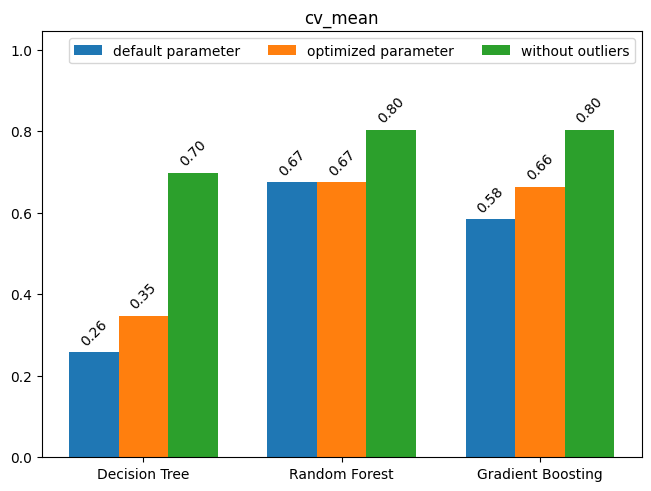

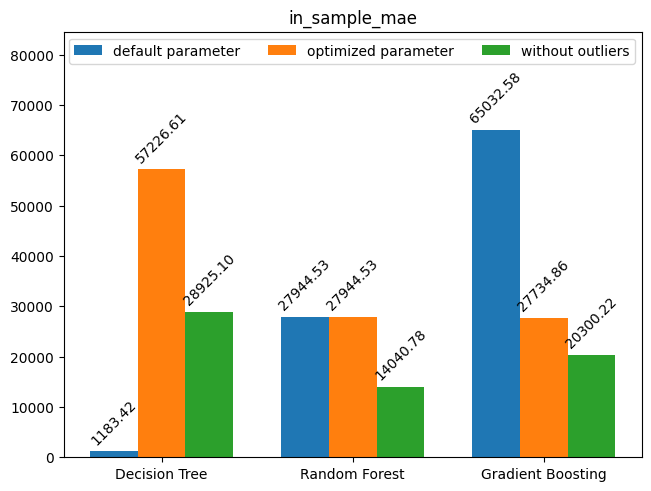

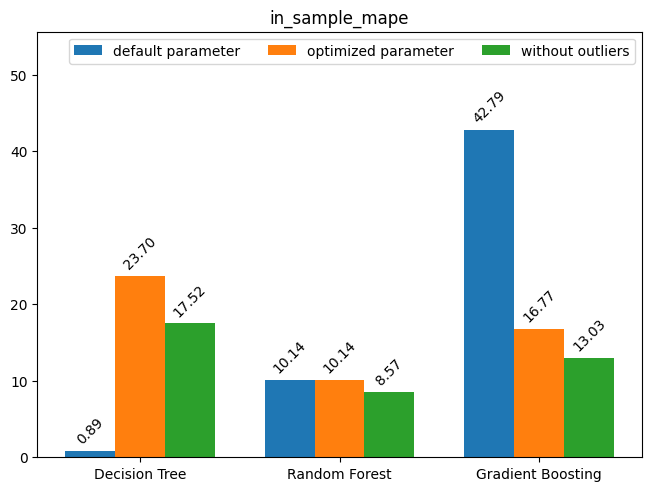

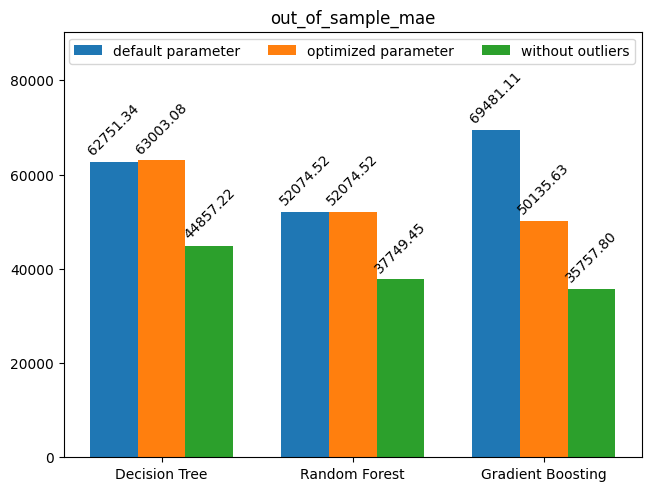

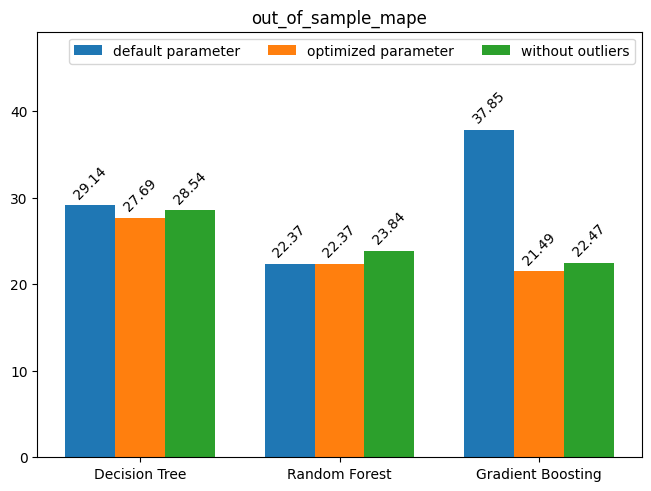

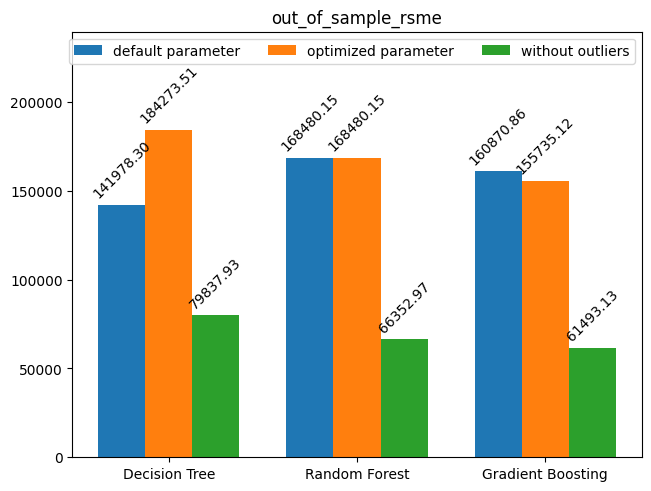

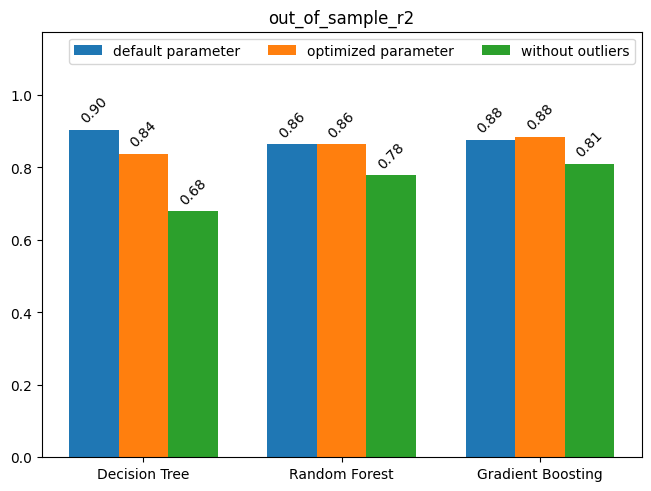

In [23]:
for column in df_metrics.columns:
    x_values = tuple(df_metrics.index.unique(level=1))
    y_values = dict([(name, group.values.flatten().tolist()) for name, group in df_metrics[column].groupby(level=0)])

    x = np.arange(len(x_values))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    ylim_max = float('-inf')

    for attribute, measurement in y_values.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, fmt='%.2f', rotation=45)
        multiplier += 1

        ylim_max = max(ylim_max, max(measurement))

    ax.set_title(f'{column}')
    ax.set_xticks(x + width, x_values)
    ax.legend(loc='best', ncols=3)
    ax.set_ylim(0, ylim_max + 0.3 * ylim_max)

    plt.show()